C:\Users\G-15\AppData\Local\Temp\ipykernel_7484\1557271268.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Training Shape: (4160, 5) (4160, 1)
Test Shape: (1041, 5) (1041, 1)
Epoch: 0, Loss: 0.010431992821395397
Epoch: 100, Loss: 2.2310980057227425e-05
Epoch: 200, Loss: 6.211463642102899e-06
Epoch: 300, Loss: 2.7255759960098658e-06
Epoch: 400, Loss: 2.3281756966753164e-06
Epoch: 500, Loss: 2.099532139254734e-06
Epoch: 600, Loss: 1.9458473161648726e-06
Epoch: 700, Loss: 1.8233704395242967e-06
Epoch: 800, Loss: 1.7258331581615494e-06
Epoch: 900, Loss: 1.6551397266084678e-06
Epoch: 1000, Loss: 1.596380457158375e-06
Epoch: 1100, Loss: 1.543958205729723e-06
Epoch: 1200, Loss: 1.5007495903773815e-06
Epoch: 1300, Loss: 1.4629605402660673e-06
Epoch: 1400, Loss: 1.4290750414147624e-06
Epoch: 1500, Loss: 1.3990413663123036e-06
Epoch: 1600, Loss: 1.3727564009968773e-06
Epoch: 1700, Loss: 1.347308625554433e-06
Epoch: 1800, Loss: 1.3210815268394072e-06
Epoch: 1900, Loss: 1.2923900385430898e-06


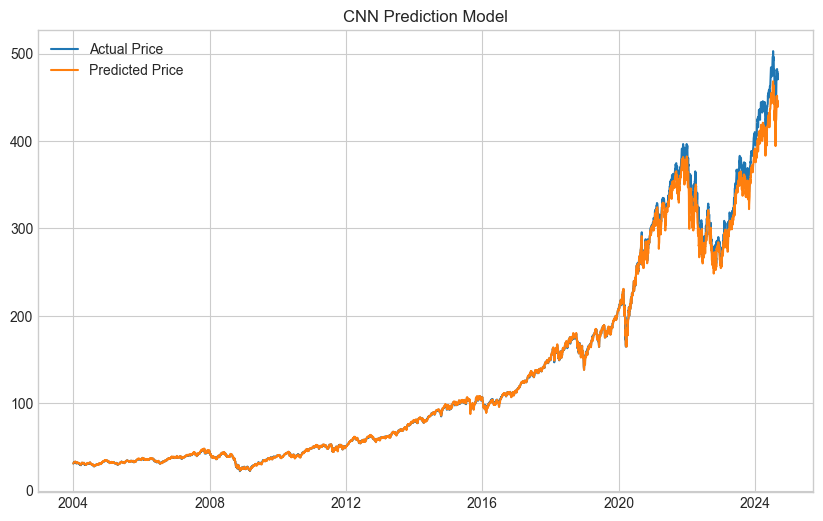

In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import dataloader
import math
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler

plt.style.use('seaborn-whitegrid')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

# QQQ 주가 데이터 다운로드
df = pd.read_csv('QQQ_2000.csv', parse_dates=['Date'], index_col='Date')

# 2004년 1월 1일부터의 데이터만 필터링
df = df[df.index >= '2004-01-01']

df.head()

# fig = df['Adj Close'].plot()
X = df.drop('Adj Close', axis=1)
y = df[['Adj Close']]

ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

# 학습 데이터를 전체 기간의 80%로 설정하고, 나머지를 테스트 데이터로 사용
train_size = int(len(X_ss) * 0.8)
X_train = X_ss[:train_size, :]
X_test = X_ss[train_size:, :]

y_train = y_ms[:train_size, :]
y_test = y_ms[train_size:, :]

print('Training Shape:', X_train.shape, y_train.shape)
print('Test Shape:', X_test.shape, y_test.shape)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# 데이터 차원을 (batch_size, 1, seq_len)으로 변경
X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self, num_classes, input_size):
        super(CNN, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 모델 학습
num_epochs = 2000
lr = 0.0001

model = CNN(num_classes=1, input_size=X_train_tensors.shape[1]).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

X_train_tensors_f = X_train_tensors_f.to(device)
y_train_tensors = y_train_tensors.to(device)

for epoch in range(num_epochs):
    outputs = model(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# 테스트 데이터 예측
df_x_ss = ss.transform(X)
df_x_ss = Variable(torch.Tensor(df_x_ss)).to(device)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.cpu().detach().numpy()

df_y_ms = y_ms
label_y = df_y_ms

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

# 시각화
plt.figure(figsize=(10, 6))

df['pred'] = predicted
plt.plot(df['Adj Close'], label='Actual Price')
plt.plot(df['pred'], label='Predicted Price')

plt.title('CNN Prediction Model')
plt.legend()
plt.show()


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5201 entries, 2004-01-02 to 2024-08-30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5201 non-null   float64
 1   High       5201 non-null   float64
 2   Low        5201 non-null   float64
 3   Close      5201 non-null   float64
 4   Adj Close  5201 non-null   float64
 5   Volume     5201 non-null   int64  
 6   pred       5201 non-null   float32
dtypes: float32(1), float64(5), int64(1)
memory usage: 304.7 KB


In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows인 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 깨지는 것을 방지

# 데이터 추출
df = df[(df.index >= '2023-01-01') & (df.index <= '2023-12-31')]

# X, y 설정
X = df.drop('Adj Close', axis=1)
y = df[['Adj Close']]

# 단순 이동평균(SMA) 계산 함수
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

# 과거 N일간 수익률 계산 함수
def calculate_past_return(data, days=5):
    return (data - data.shift(days)) / data.shift(days) * 100

# 여기서 예측값을 실제 'Adj Close'의 이전 데이터로 간주하여 예측값 설정
predicted = df['Adj Close'].values

# 초기 자본 및 상태 설정
initial_capital = 1000000  # 초기 자본 100만원
capital = initial_capital
shares = 0  # 보유 주식 수
transactions = []  # 각 일자별 거래 내역 저장
total_value_history = []  # 총 자산(현금+주식)의 역사

# 1. 초기 자본으로 100% 매수
# train_size를 0으로 설정하여 데이터를 처음부터 사용
train_size = 0  

initial_buy_price = df['Adj Close'].iloc[train_size]
shares = int(capital / initial_buy_price)  # 초기 자본으로 매수 가능한 정수 주식 수
capital = capital - (shares * initial_buy_price)  # 남은 자본 (소수점 제외)
transactions.append((df.index[train_size], 'Initial Buy', shares, initial_buy_price, capital))
print(f"Initial Buy: {shares} shares at {initial_buy_price}")

# 매수 후 초기 자산(총 자산 = 보유 주식의 가치)
initial_total_value = shares * initial_buy_price
total_value_history.append(initial_total_value)

# 매수/매도 신호 기록
buy_signals = []
sell_signals = []

# 매수 및 매도 전략 수행 (예측값을 기준으로)
for i in range(train_size + 1, len(predicted)):
    close_price = df['Adj Close'].iloc[i]
    predicted_today = predicted[i]
    predicted_yesterday = predicted[i - 1]
    
    # 매수 조건: 예측값이 전일 예측값보다 1% 이상 상승할 때
    if predicted_today > predicted_yesterday * 1.01:
        if capital > 0:
            buy_shares = int(capital / close_price)  # 매수 가능한 정수 주식 수
            if buy_shares >= 1:  # 최소 1주 이상만 매수 가능
                capital -= buy_shares * close_price
                shares += buy_shares
                transactions.append((df.index[i], 'Buy', buy_shares, close_price, capital))
                buy_signals.append((df.index[i], close_price))
    
    # 매도 조건: 예측값이 전일 예측값보다 1% 이상 하락할 때
    elif predicted_today < predicted_yesterday * 0.99:
        if shares > 0:
            sell_shares = shares  # 전량 매도
            if sell_shares >= 1:  # 최소 1주 이상만 매도 가능
                capital += sell_shares * close_price
                shares = 0
                transactions.append((df.index[i], 'Sell', sell_shares, close_price, capital))
                sell_signals.append((df.index[i], close_price))
    
    # 총 자산 계산 (현금 + 보유 주식의 현재 가치)
    total_value = capital + shares * close_price
    total_value_history.append(total_value)

# Buy and Hold 전략
buy_hold_shares = int(initial_capital / df['Close'].iloc[train_size])
buy_hold_value_history = df['Adj Close'].iloc[train_size:] * buy_hold_shares

# 수익률 계산
total_return = (total_value_history[-1] - initial_capital) / initial_capital * 100
buy_hold_return = (buy_hold_value_history.iloc[-1] - initial_capital) / initial_capital * 100
print(f"최종 수익률 (매매 전략): {total_return:.2f}%")
print(f"최종 수익률 (Buy and Hold): {buy_hold_return:.2f}%")


# 거래 내역을 pandas DataFrame으로 변환
transactions_df = pd.DataFrame(transactions, columns=['날짜', '유형', '주식 수', '가격', '남은 자본'])

# 거래 내역을 CSV 파일로 저장
transactions_df.to_csv('transactions_history.csv', index=False, encoding='utf-8-sig')

print("거래 내역이 'transactions_history.csv' 파일로 저장되었습니다.")

Initial Buy: 3818 shares at 261.9020690917969
최종 수익률 (매매 전략): 33.73%
최종 수익률 (Buy and Hold): 54.39%
거래 내역이 'transactions_history.csv' 파일로 저장되었습니다.


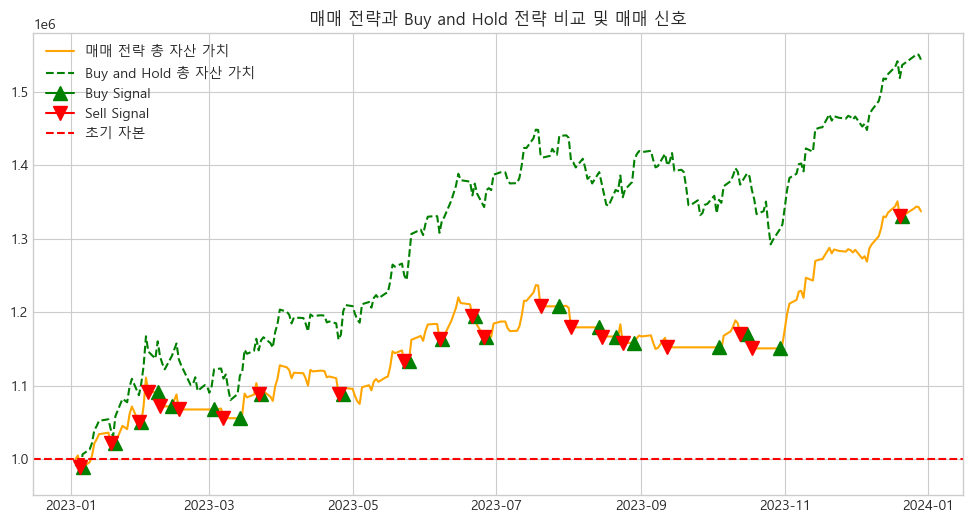

In [16]:
# 매매 전략과 Buy and Hold 전략 비교 시각화 (하나의 차트로 합치기)
plt.figure(figsize=(12, 6))

# 매매 전략의 총 자산 가치 (x축과 y축의 길이가 일치하도록 슬라이스)
plt.plot(df.index[train_size:train_size+len(total_value_history)], total_value_history[:len(df.index[train_size:])], label='매매 전략 총 자산 가치', color='orange')

# Buy and Hold 전략의 자산 가치
plt.plot(buy_hold_value_history.index, buy_hold_value_history.values, label='Buy and Hold 총 자산 가치', linestyle='--', color='green')

# 매수/매도 시점 표시 (매매 전략 총 자산 가치의 y축에 맞추기)
# 매수 신호는 처음 한 번만 레전드에 추가
first_buy_signal = True
for i, buy_signal in enumerate(buy_signals):
    buy_index = df.index.get_loc(buy_signal[0])  # buy_signal[0]은 신호가 발생한 날짜
    total_value_at_buy = total_value_history[buy_index - train_size]  # 매매 전략 총 자산 가치에서 y축 좌표 추출

    if first_buy_signal:
        plt.plot(buy_signal[0], total_value_at_buy, marker='^', color='green', markersize=10, label='Buy Signal')
        first_buy_signal = False
    else:
        plt.plot(buy_signal[0], total_value_at_buy, marker='^', color='green', markersize=10)

# 매도 신호는 처음 한 번만 레전드에 추가
first_sell_signal = True
for i, sell_signal in enumerate(sell_signals):
    sell_index = df.index.get_loc(sell_signal[0])  # sell_signal[0]은 신호가 발생한 날짜
    total_value_at_sell = total_value_history[sell_index - train_size]  # 매매 전략 총 자산 가치에서 y축 좌표 추출

    if first_sell_signal:
        plt.plot(sell_signal[0], total_value_at_sell, marker='v', color='red', markersize=10, label='Sell Signal')
        first_sell_signal = False
    else:
        plt.plot(sell_signal[0], total_value_at_sell, marker='v', color='red', markersize=10)

# 초기 자본 기준선
plt.axhline(initial_capital, color='r', linestyle='--', label='초기 자본')

plt.title('매매 전략과 Buy and Hold 전략 비교 및 매매 신호')
plt.legend()
plt.show()
